In [1]:
import torch
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics
import time

from torch import nn
from copy import deepcopy
from torch.nn import functional as F
from tqdm import tqdm

In [2]:
# Use the following gym version.
# pip install gym==0.25.0
# pip install pygame

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# define global variable 
env = gym.make('LunarLander-v2')
pop_size = 200
gens = 150
elit = int(pop_size * 0.4)
tot_size = 5
MAX_EP = 1

/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def calculate_fitness(network, env, num_episodes=MAX_EP):
    total_rewards = 0
    for _ in range(num_episodes):
        reward, _ = run_episode(network, env)
        total_rewards += reward
    avg_reward = total_rewards / num_episodes
    return avg_reward

In [5]:
def run_episode(network, env):
    state = env.reset()
    total_reward = 0.0
    log_probs = []  # Store log probabilities of actions
    done = False
    while not done:
        state_t = torch.as_tensor(state, dtype=torch.float32)
        q_values = network(state_t.unsqueeze(0))
        action_probs = nn.functional.softmax(q_values, dim=1)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        log_probs.append(log_prob)
        state, reward, done, _ = env.step(action.item())
        total_reward += reward
    return total_reward, log_probs

In [6]:
def mutate_and_tournament(population, tournament_size, mutation_rate, mutation_strength):
    
    # Select individuals for the tournament
    individuals = random.sample(population, tournament_size)
    # Calculate fitness for each individual
    fitnesses = [calculate_fitness(individual, env) for individual in individuals]
    # Select the best individual
    parent = individuals[np.argmax(fitnesses)]
    # Create offspring by deep copying the parent
    offspring = deepcopy(parent)
    
    # Apply mutation
    with torch.no_grad():
        for param in offspring.parameters():
            if random.random() < mutation_rate:
                delta = torch.randn_like(param)
                param.add_(mutation_strength * delta)
    
    # Return the mutated offspring
    return offspring

In [7]:
# Define genetic algorithm
def main(POPULATION_SIZE, GENERATIONS, ELITISM, TOURNAMENT_SIZE, MUTATION_STRENGTH, MUTATION_RATE):
    
    start_time = time.time()
    
    FITNESS_HISTORY = list()
    FITNESS_STDERROR_HISTORY = list()
    
    # Create initial population
    population = [PolicyNetwork(8, 4) for _ in range(POPULATION_SIZE)]

    for generation in range(1, GENERATIONS + 1):

        # Calculate fitness for each network
        fitnesses = [calculate_fitness(network, env) for network in tqdm(population, desc="Calculating fitnesses")]
        
        # average fitness 
        avg_fitness = np.average(fitnesses)
        max_fitness = np.max(fitnesses)
        min_fitness = np.min(fitnesses)
        FITNESS_HISTORY.append([avg_fitness, max_fitness, min_fitness])
        
        # std error
        standard_deviation = statistics.stdev(fitnesses)
        standard_error = standard_deviation / (POPULATION_SIZE ** 0.5)
        FITNESS_STDERROR_HISTORY.append(standard_error)

        print(f"[Generation: {generation}] \n Average Fitness: {avg_fitness} \n Best Fitness: {max_fitness} \n Worst Fitness: {min_fitness} \n Standard Error: {standard_error}")
        
        # Sort population by fitness
        population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
        
        # Select the best networks to pass their genes to the next generation
        survivors = population[:ELITISM]
        
        # Create the next generation
        next_population = survivors  # Start with the survivors
        
        num_individuals_to_add = POPULATION_SIZE - len(next_population)
        # Add offspring by tournament selection and mutation
        for _ in tqdm(range(num_individuals_to_add), desc="Generating Offspring"):
            offspring = mutate_and_tournament(population, TOURNAMENT_SIZE, MUTATION_RATE, MUTATION_STRENGTH)
            next_population.append(offspring)

        # The next generation becomes the current population
        population = next_population
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return population, FITNESS_HISTORY, FITNESS_STDERROR_HISTORY

### Version Control

In [8]:
# Version 1:
# Run the genetic algorithm
population, history, history_std = main(POPULATION_SIZE=pop_size, 
                            GENERATIONS=gens, 
                            ELITISM=elit, 
                            TOURNAMENT_SIZE=tot_size, 
                            MUTATION_STRENGTH=1, 
                            MUTATION_RATE=0.01)

Calculating fitnesses:   0%|                                                                                                                                   | 0/200 [00:00<?, ?it/s]/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.74it/s]


[Generation: 1] 
 Average Fitness: -178.37858913069238 
 Best Fitness: 63.84055452983209 
 Worst Fitness: -562.9074785508433 
 Standard Error: 8.345884092456139


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 60.08it/s]


[Generation: 2] 
 Average Fitness: -193.28324247156263 
 Best Fitness: 40.53426305915778 
 Worst Fitness: -570.4638583566687 
 Standard Error: 8.570453421793122


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.59it/s]


[Generation: 3] 
 Average Fitness: -187.4576073009811 
 Best Fitness: 43.792890487757035 
 Worst Fitness: -506.90509623701087 
 Standard Error: 7.848670357380611


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 41.19it/s]


[Generation: 4] 
 Average Fitness: -192.89434033354067 
 Best Fitness: 120.09894791800242 
 Worst Fitness: -933.4564145000171 
 Standard Error: 9.490819506454082


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 59.20it/s]


[Generation: 5] 
 Average Fitness: -187.49856170968607 
 Best Fitness: 56.586110603830235 
 Worst Fitness: -568.3677418576772 
 Standard Error: 8.17975236342008


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.19it/s]


[Generation: 6] 
 Average Fitness: -183.4043988932026 
 Best Fitness: 43.43299160877246 
 Worst Fitness: -591.3294134909054 
 Standard Error: 8.286992198881624


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.78it/s]


[Generation: 7] 
 Average Fitness: -180.7320030185438 
 Best Fitness: 60.93476487613455 
 Worst Fitness: -521.3039661689952 
 Standard Error: 8.447875531788574


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 59.36it/s]


[Generation: 8] 
 Average Fitness: -177.09326803437915 
 Best Fitness: 17.771731235435567 
 Worst Fitness: -587.0130941246623 
 Standard Error: 8.168658703073131


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.67it/s]


[Generation: 9] 
 Average Fitness: -187.42501068330304 
 Best Fitness: 17.09727638694119 
 Worst Fitness: -579.2538266924377 
 Standard Error: 8.508576492239143


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 55.87it/s]


[Generation: 10] 
 Average Fitness: -208.23173959635585 
 Best Fitness: 25.181564605725995 
 Worst Fitness: -611.0488381777495 
 Standard Error: 8.588621108401421


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.22it/s]


[Generation: 11] 
 Average Fitness: -200.76528727711008 
 Best Fitness: 49.369072242614436 
 Worst Fitness: -809.9303689065656 
 Standard Error: 8.366614734243853


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.22it/s]


[Generation: 12] 
 Average Fitness: -185.14572322854306 
 Best Fitness: 109.18625233069739 
 Worst Fitness: -518.1866376144797 
 Standard Error: 8.143843228257909


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.39it/s]


[Generation: 13] 
 Average Fitness: -179.0571931045664 
 Best Fitness: 46.38089303842537 
 Worst Fitness: -541.9296401996052 
 Standard Error: 7.769761297978601


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.19it/s]


[Generation: 14] 
 Average Fitness: -183.3813995266627 
 Best Fitness: 66.75113797881576 
 Worst Fitness: -591.8395044506509 
 Standard Error: 8.038236800302984


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.21it/s]


[Generation: 15] 
 Average Fitness: -192.7433530722294 
 Best Fitness: 43.56990095588452 
 Worst Fitness: -806.1536451375714 
 Standard Error: 8.931170588917423


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.65it/s]


[Generation: 16] 
 Average Fitness: -206.44228650647116 
 Best Fitness: -11.165881241912814 
 Worst Fitness: -585.120374516324 
 Standard Error: 8.692829373427266


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.89it/s]


[Generation: 17] 
 Average Fitness: -190.46395088307597 
 Best Fitness: -15.968824856546746 
 Worst Fitness: -667.7833948387207 
 Standard Error: 8.3530177024939


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.32it/s]


[Generation: 18] 
 Average Fitness: -198.7828300960748 
 Best Fitness: 46.41744162330096 
 Worst Fitness: -615.2116787345716 
 Standard Error: 8.884156425776364


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.50it/s]


[Generation: 19] 
 Average Fitness: -180.34014568942285 
 Best Fitness: 34.92779180882093 
 Worst Fitness: -532.489340087972 
 Standard Error: 7.3555467044857945


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.46it/s]


[Generation: 20] 
 Average Fitness: -186.74949279618787 
 Best Fitness: 11.348861742602978 
 Worst Fitness: -525.1073335978007 
 Standard Error: 7.212601436065455


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.25it/s]


[Generation: 21] 
 Average Fitness: -181.5918212936193 
 Best Fitness: 29.852307793079575 
 Worst Fitness: -590.194285787531 
 Standard Error: 7.723114534903741


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.42it/s]


[Generation: 22] 
 Average Fitness: -188.32981613806223 
 Best Fitness: 31.86354037866903 
 Worst Fitness: -609.0071180343209 
 Standard Error: 8.682113833598542


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 61.86it/s]


[Generation: 23] 
 Average Fitness: -181.07596529703062 
 Best Fitness: 27.383130182212497 
 Worst Fitness: -628.3780959277914 
 Standard Error: 8.341072636191434


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 62.15it/s]


[Generation: 24] 
 Average Fitness: -188.72513316052783 
 Best Fitness: -2.7301229769661575 
 Worst Fitness: -1032.4052527966564 
 Standard Error: 8.864367949482702


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.93it/s]


[Generation: 25] 
 Average Fitness: -181.29236647114837 
 Best Fitness: 9.194579578272311 
 Worst Fitness: -699.8482855860073 
 Standard Error: 8.2234604864427


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.82it/s]


[Generation: 26] 
 Average Fitness: -196.60927308764272 
 Best Fitness: 74.28030976060552 
 Worst Fitness: -1631.202641202095 
 Standard Error: 10.353580534584005


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.48it/s]


[Generation: 27] 
 Average Fitness: -183.36322534354062 
 Best Fitness: -14.253857621708363 
 Worst Fitness: -600.6982959674468 
 Standard Error: 8.12456025553716


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 61.92it/s]


[Generation: 28] 
 Average Fitness: -181.65286892269629 
 Best Fitness: 16.707196227576816 
 Worst Fitness: -462.49576017198467 
 Standard Error: 7.515825906716067


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.55it/s]


[Generation: 29] 
 Average Fitness: -190.44593769182427 
 Best Fitness: 46.68519011064399 
 Worst Fitness: -563.729650718459 
 Standard Error: 8.541664453607305


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.40it/s]


[Generation: 30] 
 Average Fitness: -179.96749557906125 
 Best Fitness: 15.03204785944888 
 Worst Fitness: -560.3420905626189 
 Standard Error: 7.304812453784453


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 61.69it/s]


[Generation: 31] 
 Average Fitness: -178.7012783642882 
 Best Fitness: 8.387522076861572 
 Worst Fitness: -554.6915604823059 
 Standard Error: 7.986621891762359


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.36it/s]


[Generation: 32] 
 Average Fitness: -179.19264417957802 
 Best Fitness: 0.35994413154510596 
 Worst Fitness: -618.6767985817356 
 Standard Error: 8.491583296269734


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 53.17it/s]


[Generation: 33] 
 Average Fitness: -151.4400179567841 
 Best Fitness: 47.72619953450633 
 Worst Fitness: -795.2518054759645 
 Standard Error: 8.116349537704203


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 62.67it/s]


[Generation: 34] 
 Average Fitness: -156.7308978941589 
 Best Fitness: 47.40178822016219 
 Worst Fitness: -463.6065703833409 
 Standard Error: 6.646818912661953


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 60.55it/s]


[Generation: 35] 
 Average Fitness: -152.33261472599773 
 Best Fitness: -8.442370140328833 
 Worst Fitness: -542.7008058680796 
 Standard Error: 7.316063393962873


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 61.42it/s]


[Generation: 36] 
 Average Fitness: -160.9543904930805 
 Best Fitness: 43.81222064099515 
 Worst Fitness: -593.3236047485533 
 Standard Error: 8.447600399409513


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.15it/s]


[Generation: 37] 
 Average Fitness: -136.22427606719347 
 Best Fitness: 14.335127002171262 
 Worst Fitness: -793.8794474087294 
 Standard Error: 6.671734578758896


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 50.81it/s]


[Generation: 38] 
 Average Fitness: -125.79799056748423 
 Best Fitness: 9.431359509529775 
 Worst Fitness: -852.370706470916 
 Standard Error: 6.363705851263532


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 59.49it/s]


[Generation: 39] 
 Average Fitness: -121.76660301236285 
 Best Fitness: -5.450637962611182 
 Worst Fitness: -756.4646781834865 
 Standard Error: 6.98078381649886


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 62.34it/s]


[Generation: 40] 
 Average Fitness: -116.47882798902091 
 Best Fitness: 11.471692638125404 
 Worst Fitness: -752.0422270407261 
 Standard Error: 6.296828029201609


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 60.70it/s]


[Generation: 41] 
 Average Fitness: -121.31162032117487 
 Best Fitness: 32.693939874436325 
 Worst Fitness: -781.7902650841114 
 Standard Error: 6.493314375542755


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 60.36it/s]


[Generation: 42] 
 Average Fitness: -117.35590939296166 
 Best Fitness: 28.738164249834483 
 Worst Fitness: -1006.3392376888818 
 Standard Error: 6.843504622254229


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.99it/s]


[Generation: 43] 
 Average Fitness: -109.21897670523543 
 Best Fitness: -20.513942302975366 
 Worst Fitness: -500.7055282480353 
 Standard Error: 4.1167385441688955


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.98it/s]


[Generation: 44] 
 Average Fitness: -121.36822616948844 
 Best Fitness: 11.785955475622927 
 Worst Fitness: -923.1032899928226 
 Standard Error: 6.576731784376416


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 46.12it/s]


[Generation: 45] 
 Average Fitness: -122.16662863300365 
 Best Fitness: -20.079570685504223 
 Worst Fitness: -822.1367448705138 
 Standard Error: 7.045207189238101


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.72it/s]


[Generation: 46] 
 Average Fitness: -120.93915219636332 
 Best Fitness: 24.33775189487831 
 Worst Fitness: -913.5963088404211 
 Standard Error: 7.953219477985959


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 53.02it/s]


[Generation: 47] 
 Average Fitness: -135.27690889303713 
 Best Fitness: -17.418715973889718 
 Worst Fitness: -1415.485336144358 
 Standard Error: 10.782452995922041


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.00it/s]


[Generation: 48] 
 Average Fitness: -113.55586164881424 
 Best Fitness: 41.84771458489632 
 Worst Fitness: -649.6999272201815 
 Standard Error: 5.425966130617935


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.98it/s]


[Generation: 49] 
 Average Fitness: -109.66846524924163 
 Best Fitness: 17.001215171817606 
 Worst Fitness: -522.117191572207 
 Standard Error: 4.617977626619798


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.29it/s]


[Generation: 50] 
 Average Fitness: -112.24403168157458 
 Best Fitness: 6.119490285137417 
 Worst Fitness: -615.1747888105932 
 Standard Error: 5.506068914692113


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 60.13it/s]


[Generation: 51] 
 Average Fitness: -112.13906689835981 
 Best Fitness: 33.641594073705335 
 Worst Fitness: -721.2973159546157 
 Standard Error: 6.15793790340681


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 59.93it/s]


[Generation: 52] 
 Average Fitness: -131.09340903319875 
 Best Fitness: 25.006970704956274 
 Worst Fitness: -1330.5420949297795 
 Standard Error: 9.905994173709097


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 36.89it/s]


[Generation: 53] 
 Average Fitness: -111.98457838323289 
 Best Fitness: 18.623616360184897 
 Worst Fitness: -727.0263797335535 
 Standard Error: 6.142331043922259


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 55.88it/s]


[Generation: 54] 
 Average Fitness: -121.9828173513487 
 Best Fitness: 25.857876124436714 
 Worst Fitness: -989.4843193639623 
 Standard Error: 7.054830875895639


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.41it/s]


[Generation: 55] 
 Average Fitness: -128.1712977571925 
 Best Fitness: 37.67268541985874 
 Worst Fitness: -1509.0802752961783 
 Standard Error: 9.984117830062905


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 50.88it/s]


[Generation: 56] 
 Average Fitness: -128.70868343107804 
 Best Fitness: 10.838856192553536 
 Worst Fitness: -941.4470932328625 
 Standard Error: 7.616357767226382


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.56it/s]


[Generation: 57] 
 Average Fitness: -143.588781759598 
 Best Fitness: 27.992387698027642 
 Worst Fitness: -593.3159817982524 
 Standard Error: 7.482312131557546


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 41.34it/s]


[Generation: 58] 
 Average Fitness: -123.661008409483 
 Best Fitness: 56.19616749248078 
 Worst Fitness: -1007.513144080381 
 Standard Error: 8.692538890286626


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 52.69it/s]


[Generation: 59] 
 Average Fitness: -133.4981432437621 
 Best Fitness: 58.38464343003409 
 Worst Fitness: -1441.5775948873415 
 Standard Error: 10.273602399403892


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 43.04it/s]


[Generation: 60] 
 Average Fitness: -128.08272694443468 
 Best Fitness: 40.10300381348708 
 Worst Fitness: -659.2592605856796 
 Standard Error: 8.156450221003482


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 55.13it/s]


[Generation: 61] 
 Average Fitness: -141.89709373786832 
 Best Fitness: 40.83708182722199 
 Worst Fitness: -1739.2012110725448 
 Standard Error: 11.709127519971963


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.86it/s]


[Generation: 62] 
 Average Fitness: -140.45952407579585 
 Best Fitness: 38.45801962793999 
 Worst Fitness: -1208.1421380113825 
 Standard Error: 9.700785290487731


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 55.51it/s]


[Generation: 63] 
 Average Fitness: -154.2129272190793 
 Best Fitness: 39.67989703846936 
 Worst Fitness: -3515.9940750270835 
 Standard Error: 21.326248737006374


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.95it/s]


[Generation: 64] 
 Average Fitness: -128.89540872784306 
 Best Fitness: 55.26368912117786 
 Worst Fitness: -532.2711745252266 
 Standard Error: 7.867975528655483


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 61.20it/s]


[Generation: 65] 
 Average Fitness: -128.06235581223814 
 Best Fitness: 46.41065419982317 
 Worst Fitness: -555.3231593358387 
 Standard Error: 8.259029232979438


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 46.99it/s]


[Generation: 66] 
 Average Fitness: -133.93620759010906 
 Best Fitness: 19.589965305871033 
 Worst Fitness: -751.6125543085411 
 Standard Error: 8.396928941080342


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.61it/s]


[Generation: 67] 
 Average Fitness: -128.96971934113193 
 Best Fitness: 40.037144132278144 
 Worst Fitness: -651.8334092081865 
 Standard Error: 8.201536204229042


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.20it/s]


[Generation: 68] 
 Average Fitness: -118.96875263297306 
 Best Fitness: 41.656500674902645 
 Worst Fitness: -540.6417641108071 
 Standard Error: 7.786756935001567


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.98it/s]


[Generation: 69] 
 Average Fitness: -105.06428364775059 
 Best Fitness: 61.156789359856475 
 Worst Fitness: -537.3366512378523 
 Standard Error: 7.213217327037635


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.95it/s]


[Generation: 70] 
 Average Fitness: -150.32021419830326 
 Best Fitness: 29.59697639987823 
 Worst Fitness: -1000.3299783106836 
 Standard Error: 11.167614627803255


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.89it/s]


[Generation: 71] 
 Average Fitness: -114.3891593563851 
 Best Fitness: 57.016868344645786 
 Worst Fitness: -568.4212738291183 
 Standard Error: 7.18360465745748


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.84it/s]


[Generation: 72] 
 Average Fitness: -108.77753646143174 
 Best Fitness: 30.28991718825938 
 Worst Fitness: -734.7995936960485 
 Standard Error: 7.961414367257802


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.78it/s]


[Generation: 73] 
 Average Fitness: -125.88806857430792 
 Best Fitness: 30.114638396123638 
 Worst Fitness: -556.3113012444768 
 Standard Error: 7.8976823312484985


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 50.75it/s]


[Generation: 74] 
 Average Fitness: -97.49686216360539 
 Best Fitness: 57.85913223777098 
 Worst Fitness: -572.7568850876593 
 Standard Error: 6.78171581489489


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.80it/s]


[Generation: 75] 
 Average Fitness: -105.62144924820545 
 Best Fitness: 22.0265905992228 
 Worst Fitness: -502.17959742413467 
 Standard Error: 6.625780092589413


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.55it/s]


[Generation: 76] 
 Average Fitness: -106.7532263027428 
 Best Fitness: 48.297872919199364 
 Worst Fitness: -753.0095656211569 
 Standard Error: 8.575255467382286


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.17it/s]


[Generation: 77] 
 Average Fitness: -96.79465620128038 
 Best Fitness: 46.75600764114853 
 Worst Fitness: -1041.0514088269206 
 Standard Error: 9.103215028602836


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.72it/s]


[Generation: 78] 
 Average Fitness: -93.80980398521712 
 Best Fitness: 34.86276277882061 
 Worst Fitness: -622.565930433681 
 Standard Error: 6.5343553855142025


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.70it/s]


[Generation: 79] 
 Average Fitness: -112.72618509445707 
 Best Fitness: 30.899526510700696 
 Worst Fitness: -772.4371682475022 
 Standard Error: 8.876770255869356


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.56it/s]


[Generation: 80] 
 Average Fitness: -102.50808065713545 
 Best Fitness: 25.267369262393217 
 Worst Fitness: -611.9249275053073 
 Standard Error: 8.565467568741118


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.26it/s]


[Generation: 81] 
 Average Fitness: -106.77415540383873 
 Best Fitness: 41.07968560407019 
 Worst Fitness: -907.2215596936236 
 Standard Error: 10.191923327093802


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 62.60it/s]


[Generation: 82] 
 Average Fitness: -100.44200734806634 
 Best Fitness: 31.996706341282135 
 Worst Fitness: -690.1890312618657 
 Standard Error: 9.220849795805199


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.45it/s]


[Generation: 83] 
 Average Fitness: -102.30246141549364 
 Best Fitness: 37.457039879172385 
 Worst Fitness: -1146.1687149241493 
 Standard Error: 9.943052650900757


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.92it/s]


[Generation: 84] 
 Average Fitness: -88.9510570689493 
 Best Fitness: 56.988829252632 
 Worst Fitness: -588.8281058883213 
 Standard Error: 7.720983507139691


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 66.98it/s]


[Generation: 85] 
 Average Fitness: -103.20974302027615 
 Best Fitness: 24.456120296358833 
 Worst Fitness: -688.031554828849 
 Standard Error: 9.147919991148418


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.67it/s]


[Generation: 86] 
 Average Fitness: -96.2441838465911 
 Best Fitness: 41.77155139437795 
 Worst Fitness: -630.9578360397211 
 Standard Error: 8.320785267320467


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.38it/s]


[Generation: 87] 
 Average Fitness: -87.20034126550809 
 Best Fitness: 53.48741455650253 
 Worst Fitness: -644.6277863864542 
 Standard Error: 8.420254796325825


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 62.81it/s]


[Generation: 88] 
 Average Fitness: -110.11984513192226 
 Best Fitness: 33.55791672219871 
 Worst Fitness: -810.5702723057193 
 Standard Error: 10.327449632446164


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.00it/s]


[Generation: 89] 
 Average Fitness: -73.02213446959242 
 Best Fitness: 26.777940055042393 
 Worst Fitness: -470.1657543181 
 Standard Error: 6.609009579060498


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.88it/s]


[Generation: 90] 
 Average Fitness: -98.01366119098822 
 Best Fitness: 57.14827549250441 
 Worst Fitness: -2329.0964945969395 
 Standard Error: 13.552949892962621


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.45it/s]


[Generation: 91] 
 Average Fitness: -83.99811582198366 
 Best Fitness: 33.90497100765566 
 Worst Fitness: -535.110053716756 
 Standard Error: 7.019444021800833


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.58it/s]


[Generation: 92] 
 Average Fitness: -95.39591675665044 
 Best Fitness: 45.91357445354609 
 Worst Fitness: -676.7496119738169 
 Standard Error: 8.892232476116972


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 65.83it/s]


[Generation: 93] 
 Average Fitness: -104.66541331535147 
 Best Fitness: 45.986027662450624 
 Worst Fitness: -755.3409914817086 
 Standard Error: 9.765701013429318


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.62it/s]


[Generation: 94] 
 Average Fitness: -97.15259697394595 
 Best Fitness: 25.733596669520594 
 Worst Fitness: -883.0946772845995 
 Standard Error: 9.027653126700972


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.83it/s]


[Generation: 95] 
 Average Fitness: -103.72778176420364 
 Best Fitness: 50.914819524729864 
 Worst Fitness: -787.09188862351 
 Standard Error: 9.27924592753816


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.89it/s]


[Generation: 96] 
 Average Fitness: -83.65854356035729 
 Best Fitness: 43.377688215949746 
 Worst Fitness: -1302.0431825243925 
 Standard Error: 9.19095971472013


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.34it/s]


[Generation: 97] 
 Average Fitness: -102.74351705189487 
 Best Fitness: 31.11101613993293 
 Worst Fitness: -573.636100408522 
 Standard Error: 8.348966037436892


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.56it/s]


[Generation: 98] 
 Average Fitness: -98.54070054221619 
 Best Fitness: 45.75030907431247 
 Worst Fitness: -555.112139394158 
 Standard Error: 8.18468344481296


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.39it/s]


[Generation: 99] 
 Average Fitness: -93.51560412601572 
 Best Fitness: 36.65708733865088 
 Worst Fitness: -893.625893501526 
 Standard Error: 9.328514262275025


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.54it/s]


[Generation: 100] 
 Average Fitness: -94.4501068912604 
 Best Fitness: 41.35372413827514 
 Worst Fitness: -951.2161462708195 
 Standard Error: 8.748826262918243


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 65.88it/s]


[Generation: 101] 
 Average Fitness: -90.37460008537458 
 Best Fitness: 36.19134159006518 
 Worst Fitness: -498.0254187031764 
 Standard Error: 7.699076407845002


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.15it/s]


[Generation: 102] 
 Average Fitness: -97.37051508666062 
 Best Fitness: 44.31642894274779 
 Worst Fitness: -986.298958284049 
 Standard Error: 10.376166225290836


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.33it/s]


[Generation: 103] 
 Average Fitness: -86.3895918490329 
 Best Fitness: 37.81934067928901 
 Worst Fitness: -482.1780498471565 
 Standard Error: 6.940999433010927


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.23it/s]


[Generation: 104] 
 Average Fitness: -98.03783313093943 
 Best Fitness: 40.2313530662353 
 Worst Fitness: -597.8968965049501 
 Standard Error: 9.15456164282547


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 65.41it/s]


[Generation: 105] 
 Average Fitness: -105.69840660120616 
 Best Fitness: 38.841852700784585 
 Worst Fitness: -592.7636281551613 
 Standard Error: 9.575519591573457


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.85it/s]


[Generation: 106] 
 Average Fitness: -82.54035409771117 
 Best Fitness: 43.34010747599132 
 Worst Fitness: -529.8181572557422 
 Standard Error: 7.563344483411322


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.79it/s]


[Generation: 107] 
 Average Fitness: -96.80758947066202 
 Best Fitness: 44.32183922990333 
 Worst Fitness: -629.2641288464632 
 Standard Error: 8.77204020786761


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.92it/s]


[Generation: 108] 
 Average Fitness: -78.13211905233906 
 Best Fitness: 38.690884346526104 
 Worst Fitness: -928.6855543220227 
 Standard Error: 8.512468314039946


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.97it/s]


[Generation: 109] 
 Average Fitness: -107.36405105936976 
 Best Fitness: 36.810145843874636 
 Worst Fitness: -789.769281651029 
 Standard Error: 8.957772279986296


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.09it/s]


[Generation: 110] 
 Average Fitness: -96.06572882163917 
 Best Fitness: 33.40327529676216 
 Worst Fitness: -2964.791145670863 
 Standard Error: 16.278487504649686


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.19it/s]


[Generation: 111] 
 Average Fitness: -99.76977116172606 
 Best Fitness: 47.92601194738637 
 Worst Fitness: -648.5709405858461 
 Standard Error: 8.803849991807933


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.95it/s]


[Generation: 112] 
 Average Fitness: -114.86755872394049 
 Best Fitness: 39.563488760149795 
 Worst Fitness: -791.3444121965392 
 Standard Error: 10.609797859590596


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 65.80it/s]


[Generation: 113] 
 Average Fitness: -102.36116038297202 
 Best Fitness: 51.00161303709527 
 Worst Fitness: -1083.8714741263957 
 Standard Error: 10.456574367251166


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.05it/s]


[Generation: 114] 
 Average Fitness: -92.57821583384644 
 Best Fitness: 47.98952924475685 
 Worst Fitness: -980.1268984547283 
 Standard Error: 9.118426988600698


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.47it/s]


[Generation: 115] 
 Average Fitness: -72.97561152304128 
 Best Fitness: 34.96650328046806 
 Worst Fitness: -512.692504702685 
 Standard Error: 7.080917390968653


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 61.52it/s]


[Generation: 116] 
 Average Fitness: -104.01550689033581 
 Best Fitness: 33.26692299625688 
 Worst Fitness: -775.2325787601881 
 Standard Error: 10.06622601329084


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.65it/s]


[Generation: 117] 
 Average Fitness: -104.5050905612674 
 Best Fitness: 35.699760792400156 
 Worst Fitness: -783.5594820571813 
 Standard Error: 9.343228807832139


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.39it/s]


[Generation: 118] 
 Average Fitness: -88.95116270291804 
 Best Fitness: 42.04215614779079 
 Worst Fitness: -745.1204326830109 
 Standard Error: 8.755118941902571


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.94it/s]


[Generation: 119] 
 Average Fitness: -94.30452027700623 
 Best Fitness: 39.50615689672165 
 Worst Fitness: -617.9737022437571 
 Standard Error: 8.877019705652192


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.75it/s]


[Generation: 120] 
 Average Fitness: -102.71407206560869 
 Best Fitness: 44.75797626449864 
 Worst Fitness: -914.6185510331791 
 Standard Error: 9.19315785555344


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.97it/s]


[Generation: 121] 
 Average Fitness: -87.00013748471761 
 Best Fitness: 42.768358024709585 
 Worst Fitness: -697.7058683054476 
 Standard Error: 7.859578268056488


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 65.57it/s]


[Generation: 122] 
 Average Fitness: -90.45547518886993 
 Best Fitness: 44.88410463997798 
 Worst Fitness: -695.6894997028223 
 Standard Error: 8.115673399081146


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.30it/s]


[Generation: 123] 
 Average Fitness: -100.03330273440706 
 Best Fitness: 48.92974824910365 
 Worst Fitness: -739.0221904232245 
 Standard Error: 9.039886578276185


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 66.48it/s]


[Generation: 124] 
 Average Fitness: -125.28036722215103 
 Best Fitness: 56.01859496871808 
 Worst Fitness: -1990.6684796705392 
 Standard Error: 15.169543158500554


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.98it/s]


[Generation: 125] 
 Average Fitness: -75.11227555735358 
 Best Fitness: 41.574077078638595 
 Worst Fitness: -453.48445089466315 
 Standard Error: 6.645339145945425


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.55it/s]


[Generation: 126] 
 Average Fitness: -96.73404504137885 
 Best Fitness: 41.847092565124086 
 Worst Fitness: -748.3939161161242 
 Standard Error: 9.584419788440124


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.50it/s]


[Generation: 127] 
 Average Fitness: -104.50065299786675 
 Best Fitness: 46.18569650458605 
 Worst Fitness: -1802.915648819587 
 Standard Error: 11.971015351850912


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.19it/s]


[Generation: 128] 
 Average Fitness: -90.49780665716395 
 Best Fitness: 21.873926410673548 
 Worst Fitness: -671.2336755217494 
 Standard Error: 7.762941840139001


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.46it/s]


[Generation: 129] 
 Average Fitness: -94.54599127746187 
 Best Fitness: 32.23233478048488 
 Worst Fitness: -578.799101852733 
 Standard Error: 7.4070144446590405


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.86it/s]


[Generation: 130] 
 Average Fitness: -97.18346445983883 
 Best Fitness: 39.90028725325561 
 Worst Fitness: -559.625179879431 
 Standard Error: 8.501887849732498


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 66.66it/s]


[Generation: 131] 
 Average Fitness: -97.56281659183944 
 Best Fitness: 47.25897102926368 
 Worst Fitness: -788.5919989934299 
 Standard Error: 9.51253872869739


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.91it/s]


[Generation: 132] 
 Average Fitness: -103.90686587708697 
 Best Fitness: 44.47651727218559 
 Worst Fitness: -560.8474820767644 
 Standard Error: 8.608193575695713


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.01it/s]


[Generation: 133] 
 Average Fitness: -93.14208879017339 
 Best Fitness: 42.4443938303244 
 Worst Fitness: -598.1936162661046 
 Standard Error: 8.018974378141168


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.40it/s]


[Generation: 134] 
 Average Fitness: -84.5829491639629 
 Best Fitness: 28.753831851118036 
 Worst Fitness: -827.8961521722103 
 Standard Error: 8.445513608551517


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.44it/s]


[Generation: 135] 
 Average Fitness: -94.50934613450427 
 Best Fitness: 28.378147129695037 
 Worst Fitness: -917.0389860835991 
 Standard Error: 9.236795968699482


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.97it/s]


[Generation: 136] 
 Average Fitness: -82.10533921944729 
 Best Fitness: 46.51265825900529 
 Worst Fitness: -551.2318386116908 
 Standard Error: 7.809309283294387


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.36it/s]


[Generation: 137] 
 Average Fitness: -105.03221312805135 
 Best Fitness: 43.270879266525384 
 Worst Fitness: -699.9221572700604 
 Standard Error: 9.297459117937887


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.37it/s]


[Generation: 138] 
 Average Fitness: -114.52434278620186 
 Best Fitness: 50.20843458292691 
 Worst Fitness: -1618.9209031687633 
 Standard Error: 11.875254843061146


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.21it/s]


[Generation: 139] 
 Average Fitness: -97.92024744449809 
 Best Fitness: 51.85267590197935 
 Worst Fitness: -1591.3209831654653 
 Standard Error: 11.83611671456174


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.56it/s]


[Generation: 140] 
 Average Fitness: -83.915967851726 
 Best Fitness: 46.38790016772069 
 Worst Fitness: -477.79950799654085 
 Standard Error: 7.545898624518537


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.51it/s]


[Generation: 141] 
 Average Fitness: -102.65933500457697 
 Best Fitness: 46.387684738936144 
 Worst Fitness: -596.98730332114 
 Standard Error: 8.436621747334172


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.79it/s]


[Generation: 142] 
 Average Fitness: -88.09921307000894 
 Best Fitness: 41.40183056123743 
 Worst Fitness: -509.4047571676842 
 Standard Error: 7.383233027864556


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.89it/s]


[Generation: 143] 
 Average Fitness: -106.93525810090973 
 Best Fitness: 22.531709449464046 
 Worst Fitness: -676.6957882008775 
 Standard Error: 8.902348191228661


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.83it/s]


[Generation: 144] 
 Average Fitness: -94.10205789351207 
 Best Fitness: 28.3550743337409 
 Worst Fitness: -580.970988985704 
 Standard Error: 8.153216663058949


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.30it/s]


[Generation: 145] 
 Average Fitness: -85.63157059171103 
 Best Fitness: 49.90473408906175 
 Worst Fitness: -782.1241420194126 
 Standard Error: 8.20755348340702


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.70it/s]


[Generation: 146] 
 Average Fitness: -83.44203415654032 
 Best Fitness: 38.277591018554745 
 Worst Fitness: -536.4447862200454 
 Standard Error: 7.415847055718106


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.68it/s]


[Generation: 147] 
 Average Fitness: -102.30798033672674 
 Best Fitness: 39.49138357343341 
 Worst Fitness: -714.2556235986783 
 Standard Error: 9.489431250034043


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.85it/s]


[Generation: 148] 
 Average Fitness: -98.09475520518137 
 Best Fitness: 32.660806588022126 
 Worst Fitness: -972.0893598006936 
 Standard Error: 9.72112182517925


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.97it/s]


[Generation: 149] 
 Average Fitness: -106.98877394730613 
 Best Fitness: 40.90226157729805 
 Worst Fitness: -1107.4129919498332 
 Standard Error: 10.1010727088782


Calculating fitnesses: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.09it/s]


[Generation: 150] 
 Average Fitness: -87.32720046553938 
 Best Fitness: 31.756951554201436 
 Worst Fitness: -794.9123182082103 
 Standard Error: 7.673691622775125


Generating Offspring: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 15.18it/s]

--- 1927.160385131836 seconds ---


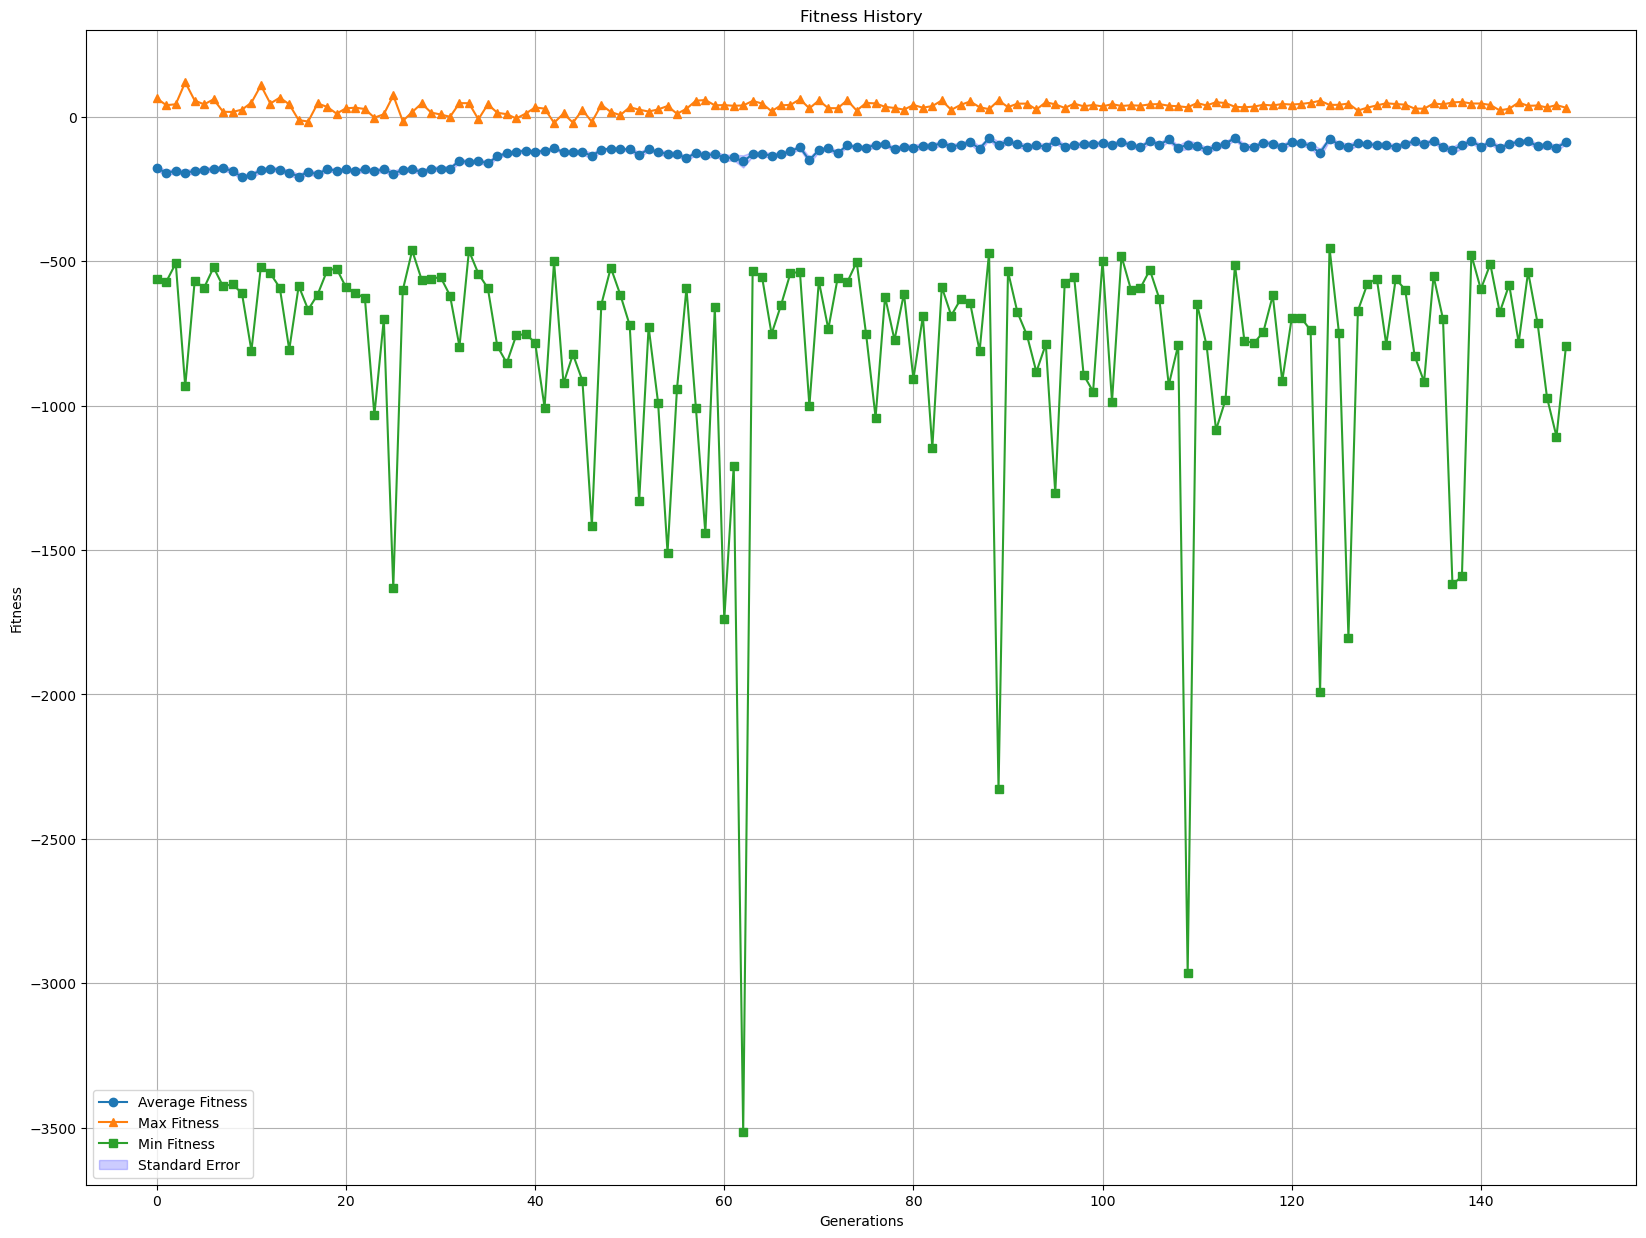

In [10]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(gens), np.array(history)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(gens), np.array(history)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(gens), np.array(history)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.fill_between(np.arange(gens), np.array(history)[:,0] - np.array(history_std), np.array(history)[:,0] + np.array(history_std),
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()

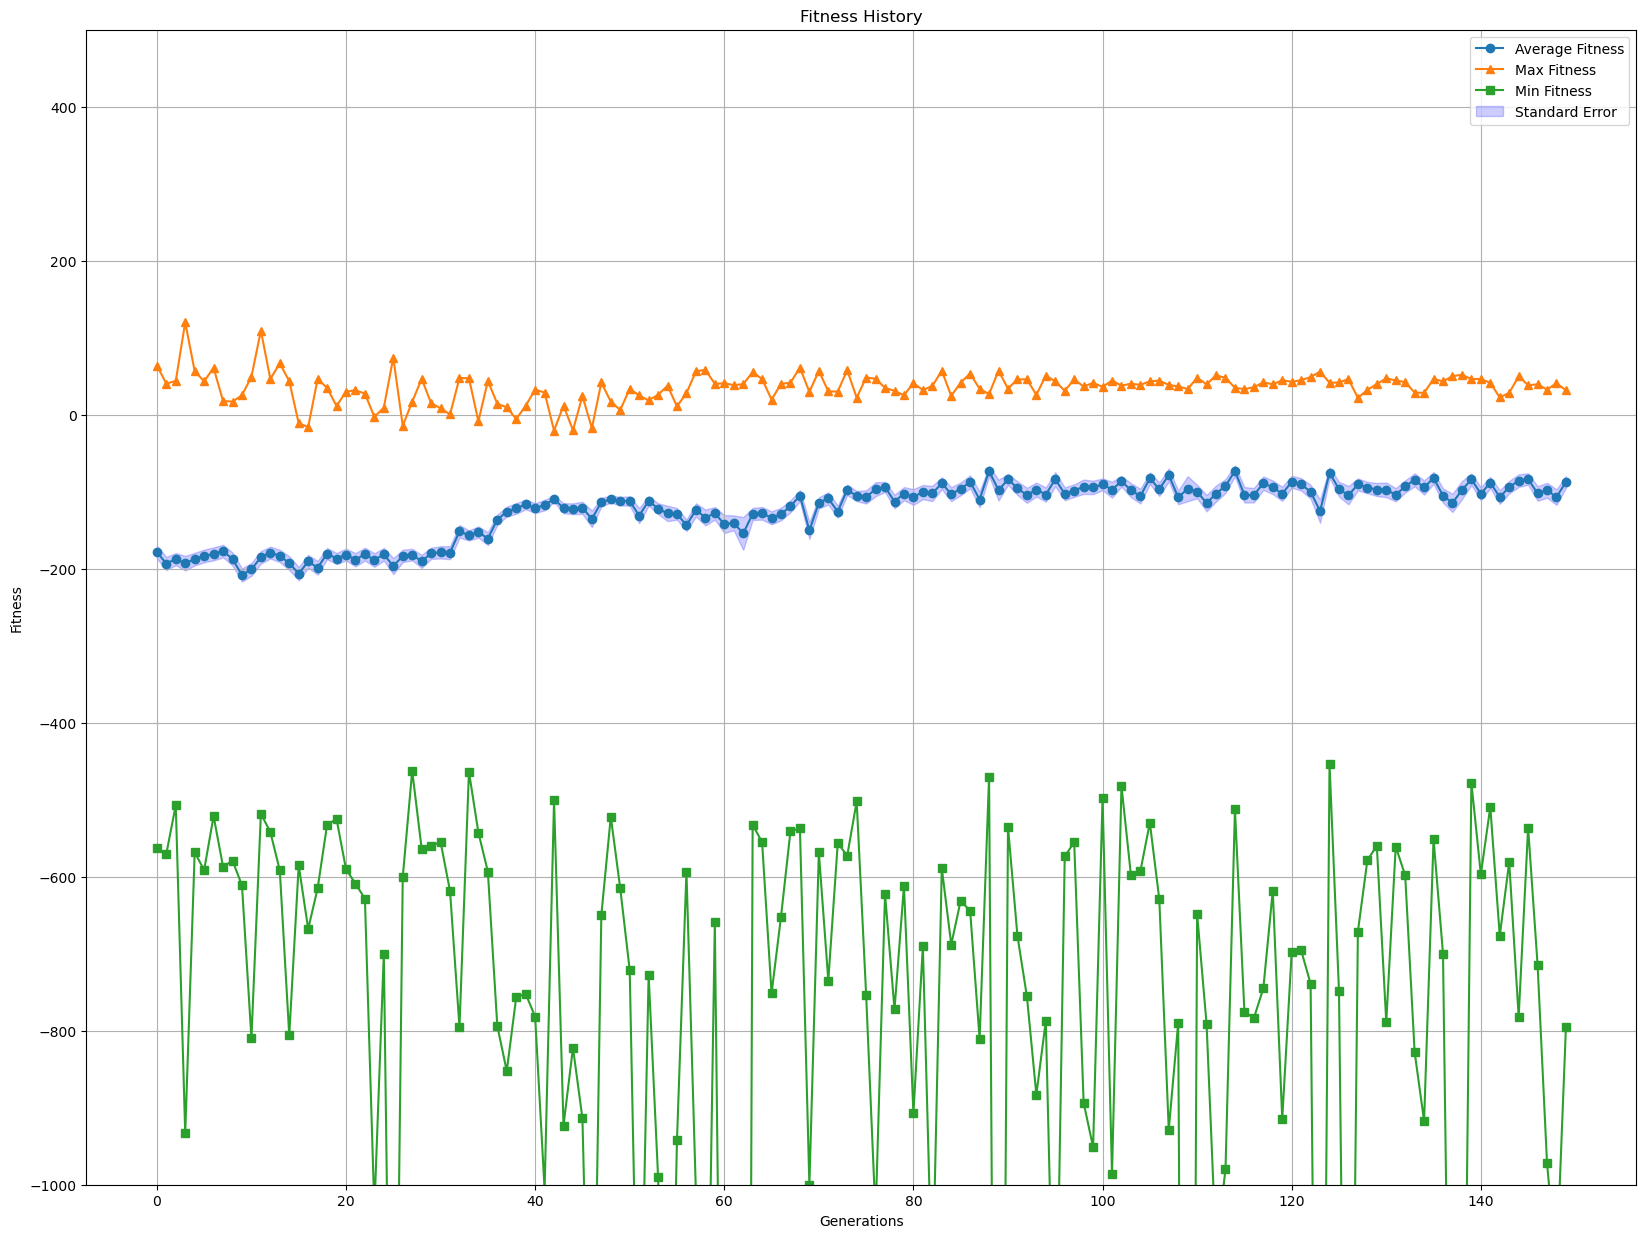

In [13]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(gens), np.array(history)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(gens), np.array(history)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(gens), np.array(history)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.fill_between(np.arange(gens), np.array(history)[:,0] - np.array(history_std), np.array(history)[:,0] + np.array(history_std),
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.ylim([-1000, 500])
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()